# Data Preprocessing

In [1]:
import tensorflow as tf

In [2]:
#Check GPU device available
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
tf.test.is_built_with_cuda()

False

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
# Load dataset
data_train = pd.read_csv('/Data/Visual Studio Code/Data-Science/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
data_test = pd.read_csv('/Data/Visual Studio Code/Data-Science/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [6]:
# Handle missing value and duplicate if any
data_train.dropna(inplace=True)
data_train.drop_duplicates(inplace=True)

data_test.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)

In [7]:
#Split Attack and Normal from dataframe
data_train_attack = data_train[data_train['label'] == 1]
data_test_attack = data_test[data_test['label'] == 1]

#Optional
#data_train_normal = data_train[data_train['label'] == 0]
#data_test_normal = data_test[data_test['label'] == 0]

In [8]:
# Drop id and label from train and test data
data_train_attack = data_train_attack.drop('id', axis=1)
data_train_attack = data_train_attack.drop('label', axis=1)

data_test_attack = data_test_attack.drop('id', axis=1)
data_test_attack = data_test_attack.drop('label', axis=1)

In [9]:
print(data_train_attack['state'].nunique())
print(data_test_attack['state'].nunique())

5
6


In [10]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ' 'RST']
['INT' 'FIN' 'ACC' 'CON' 'REQ' 'CLO']


In [11]:
#Drop ACC, CLO, and RST from data
data_train_attack = data_train_attack[(data_train_attack['state'] != 'RST')]
data_test_attack = data_test_attack[(data_test_attack['state'] != 'ACC') & (data_test_attack['state'] != 'CLO')]

In [12]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ']
['INT' 'FIN' 'CON' 'REQ']


## Encode Train and Test Data

In [13]:
#column to encode
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [14]:
#One-hot Encoding
# Encode train data
data_train_attack = pd.get_dummies(data_train_attack, columns=cols)

# Encode test data
data_test_attack = pd.get_dummies(data_test_attack, columns=cols)

In [15]:
train_attack_cat = data_train_attack.pop('attack_cat')
test_attack_cat = data_test_attack.pop('attack_cat')

## Normalization

In [16]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_norm = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 
                'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 
                'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 
                'ct_srv_dst', 'is_sm_ips_ports']

data_train_attack[cols_to_norm] = scaler.fit_transform(data_train_attack[cols_to_norm])
data_test_attack[cols_to_norm] = scaler.fit_transform(data_test_attack[cols_to_norm])

## Feature Selection

In [17]:
#Feature Selection
feature = data_train_attack.drop(['dinpkt', 'ct_ftp_cmd', 'is_sm_ips_ports'], axis=1)
feature.dtypes

dur               float64
spkts             float64
dpkts             float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 182, dtype: object

# Initialize Data

In [18]:
#Splitting the dataset into dependent and independent feature
X_train = feature
y_train = train_attack_cat

X_test = data_test_attack.drop(columns=['dinpkt', 'ct_ftp_cmd', 'is_sm_ips_ports'])
y_test = test_attack_cat

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((119329, 182), (119329,), (45329, 182), (45329,))

# Model Architecture

In [19]:
# import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from keras.metrics import Recall, Precision

## 1D-CNN Model

In [20]:
# Define the input shape
input_shape = (182, 1)

#Create the sequential model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2)) # reduces the spatial dimensions of the output volume
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(GlobalAveragePooling1D()) # computes the average of all values across the spatial dimensions, effectively flattening the data
model.add(Dropout(0.5)) # helps prevent overfitting by randomly setting a fraction of input units to 0 during training
model.add(Dense(256, activation='relu'))
model.add(Dense(9, activation='softmax'))

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [21]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 180, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 90, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 88, 128)           24704     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               3

## Train the model

In [22]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [23]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [24]:
num_class = 9
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

In [25]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [26]:
#Define epochs and batch size
epochs = 10
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10
3730/3730 [==============================] - 71s 19ms/step - loss: 1.0910 - accuracy: 0.6015 - recall: 0.3912 - precision: 0.8370 - val_loss: 0.9123 - val_accuracy: 0.6935 - val_recall: 0.5723 - val_precision: 0.8474
Epoch 2/10
3730/3730 [==============================] - 77s 21ms/step - loss: 0.8855 - accuracy: 0.6738 - recall: 0.5286 - precision: 0.8533 - val_loss: 0.8807 - val_accuracy: 0.6888 - val_recall: 0.5841 - val_precision: 0.8429
Epoch 3/10
3730/3730 [==============================] - 46s 12ms/step - loss: 0.8338 - accuracy: 0.6981 - recall: 0.5381 - precision: 0.8687 - val_loss: 0.7705 - val_accuracy: 0.7291 - val_recall: 0.5999 - val_precision: 0.8925
Epoch 4/10
3730/3730 [==============================] - 48s 13ms/step - loss: 0.7926 - accuracy: 0.7132 - recall: 0.5589 - precision: 0.8754 - val_loss: 0.7444 - val_accuracy: 0.7399 - val_recall: 0.6365 - val_precision: 0.8892
Epoch 5/10
3730/3730 [==============================] - 40s 11ms/step - loss: 0.7625 - a

In [27]:
#Define epochs and batch size
epochs = 20
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/20
3730/3730 [==============================] - 35s 9ms/step - loss: 0.6806 - accuracy: 0.7554 - recall: 0.6371 - precision: 0.8775 - val_loss: 0.7032 - val_accuracy: 0.7538 - val_recall: 0.6574 - val_precision: 0.8911
Epoch 2/20
3730/3730 [==============================] - 35s 9ms/step - loss: 0.6728 - accuracy: 0.7572 - recall: 0.6406 - precision: 0.8778 - val_loss: 0.7056 - val_accuracy: 0.7495 - val_recall: 0.6664 - val_precision: 0.8755
Epoch 3/20
3730/3730 [==============================] - 33s 9ms/step - loss: 0.6658 - accuracy: 0.7592 - recall: 0.6436 - precision: 0.8809 - val_loss: 0.6860 - val_accuracy: 0.7537 - val_recall: 0.6704 - val_precision: 0.8833
Epoch 4/20
3730/3730 [==============================] - 33s 9ms/step - loss: 0.6604 - accuracy: 0.7612 - recall: 0.6482 - precision: 0.8802 - val_loss: 0.6975 - val_accuracy: 0.7527 - val_recall: 0.6767 - val_precision: 0.8838
Epoch 5/20
3730/3730 [==============================] - 37s 10ms/step - loss: 0.6561 - accur

In [28]:
#Define epochs and batch size
epochs = 30
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/30
3730/3730 [==============================] - 39s 10ms/step - loss: 0.6147 - accuracy: 0.7739 - recall: 0.6616 - precision: 0.8930 - val_loss: 0.7326 - val_accuracy: 0.7504 - val_recall: 0.6634 - val_precision: 0.8852
Epoch 2/30
3730/3730 [==============================] - 39s 10ms/step - loss: 0.6132 - accuracy: 0.7735 - recall: 0.6629 - precision: 0.8944 - val_loss: 0.7567 - val_accuracy: 0.7425 - val_recall: 0.6605 - val_precision: 0.8810
Epoch 3/30
3730/3730 [==============================] - 39s 10ms/step - loss: 0.6129 - accuracy: 0.7741 - recall: 0.6614 - precision: 0.8929 - val_loss: 0.7174 - val_accuracy: 0.7466 - val_recall: 0.6674 - val_precision: 0.8883
Epoch 4/30
3730/3730 [==============================] - 39s 11ms/step - loss: 0.6093 - accuracy: 0.7751 - recall: 0.6638 - precision: 0.8953 - val_loss: 0.7536 - val_accuracy: 0.7467 - val_recall: 0.6642 - val_precision: 0.8710
Epoch 5/30
3730/3730 [==============================] - 38s 10ms/step - loss: 0.6108 - a

In [29]:
#Define epochs and batch size
epochs = 40
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
3730/3730 [==============================] - 42s 11ms/step - loss: 0.5821 - accuracy: 0.7828 - recall: 0.6713 - precision: 0.9043 - val_loss: 0.7768 - val_accuracy: 0.7350 - val_recall: 0.6549 - val_precision: 0.8767
Epoch 2/40
3730/3730 [==============================] - 42s 11ms/step - loss: 0.5823 - accuracy: 0.7817 - recall: 0.6689 - precision: 0.9066 - val_loss: 0.7862 - val_accuracy: 0.7402 - val_recall: 0.6605 - val_precision: 0.8655
Epoch 3/40
3730/3730 [==============================] - 41s 11ms/step - loss: 0.5804 - accuracy: 0.7833 - recall: 0.6697 - precision: 0.9076 - val_loss: 0.7900 - val_accuracy: 0.7404 - val_recall: 0.6605 - val_precision: 0.8772
Epoch 4/40
3730/3730 [==============================] - 42s 11ms/step - loss: 0.5789 - accuracy: 0.7835 - recall: 0.6701 - precision: 0.9077 - val_loss: 0.8344 - val_accuracy: 0.7387 - val_recall: 0.6612 - val_precision: 0.8648
Epoch 5/40
3730/3730 [==============================] - 42s 11ms/step - loss: 0.5787 - a

In [30]:
#Define epochs and batch size
epochs = 50
batch_size = 32

#Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
3730/3730 [==============================] - 35s 9ms/step - loss: 0.5593 - accuracy: 0.7880 - recall: 0.6771 - precision: 0.9109 - val_loss: 0.8196 - val_accuracy: 0.7465 - val_recall: 0.6577 - val_precision: 0.8904
Epoch 2/50
3730/3730 [==============================] - 35s 9ms/step - loss: 0.5598 - accuracy: 0.7883 - recall: 0.6776 - precision: 0.9109 - val_loss: 0.8051 - val_accuracy: 0.7431 - val_recall: 0.6635 - val_precision: 0.8816
Epoch 3/50
3730/3730 [==============================] - 34s 9ms/step - loss: 0.5584 - accuracy: 0.7893 - recall: 0.6770 - precision: 0.9135 - val_loss: 0.8719 - val_accuracy: 0.7140 - val_recall: 0.6464 - val_precision: 0.8598
Epoch 4/50
3730/3730 [==============================] - 35s 9ms/step - loss: 0.5591 - accuracy: 0.7891 - recall: 0.6784 - precision: 0.9121 - val_loss: 0.8133 - val_accuracy: 0.7426 - val_recall: 0.6612 - val_precision: 0.8896
Epoch 5/50
3730/3730 [==============================] - 34s 9ms/step - loss: 0.5584 - accura

## Evaluate The Model

In [31]:
#Evaluate the model on test data
loss, accuracy, recall, precision = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Recall:', recall)
print('Test Precision:', precision)

1417/1417 [==============================] - 5s 3ms/step - loss: 0.7994 - accuracy: 0.7460 - recall: 0.6565 - precision: 0.8821
Test Loss: 0.7994279265403748
Test Accuracy: 0.7460125088691711
Test Recall: 0.6565113067626953
Test Precision: 0.882061779499054


In [32]:
# make a predictions
predictions = model.predict(X_test)

1417/1417 [==============================] - 4s 3ms/step


In [33]:
# convert one-hot encode predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

### Confusion Matrix

In [34]:
# function to calculate recall from confusion matrix
def calculate_recall(confusion_matrix):
    num_class = len(confusion_matrix)
    recalls = []

    for i in range(num_class):
        true_positive = confusion_matrix[i][i]
        false_negative = sum(confusion_matrix[i]) - true_positive

        recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
    
    return recalls

In [35]:
# function to display the recall score
def display_recall(recalls):
    print('Recall Scores for each class:')
    print('Analysis:', recalls[0])
    print('Backdoor:', recalls[1])
    print('DoS:', recalls[2])
    print('Exploits:', recalls[3])
    print('Fuzzers:', recalls[4])
    print('Generic:', recalls[5])
    print('Reconnaissance:', recalls[6])
    print('Shellcode:', recalls[7])
    print('Worms:', recalls[8])

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
matrix = confusion_matrix(y_test_categorical, predicted_classes)
matrix_df = pd.DataFrame(matrix, 
                         index= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'], 
                         columns= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'])

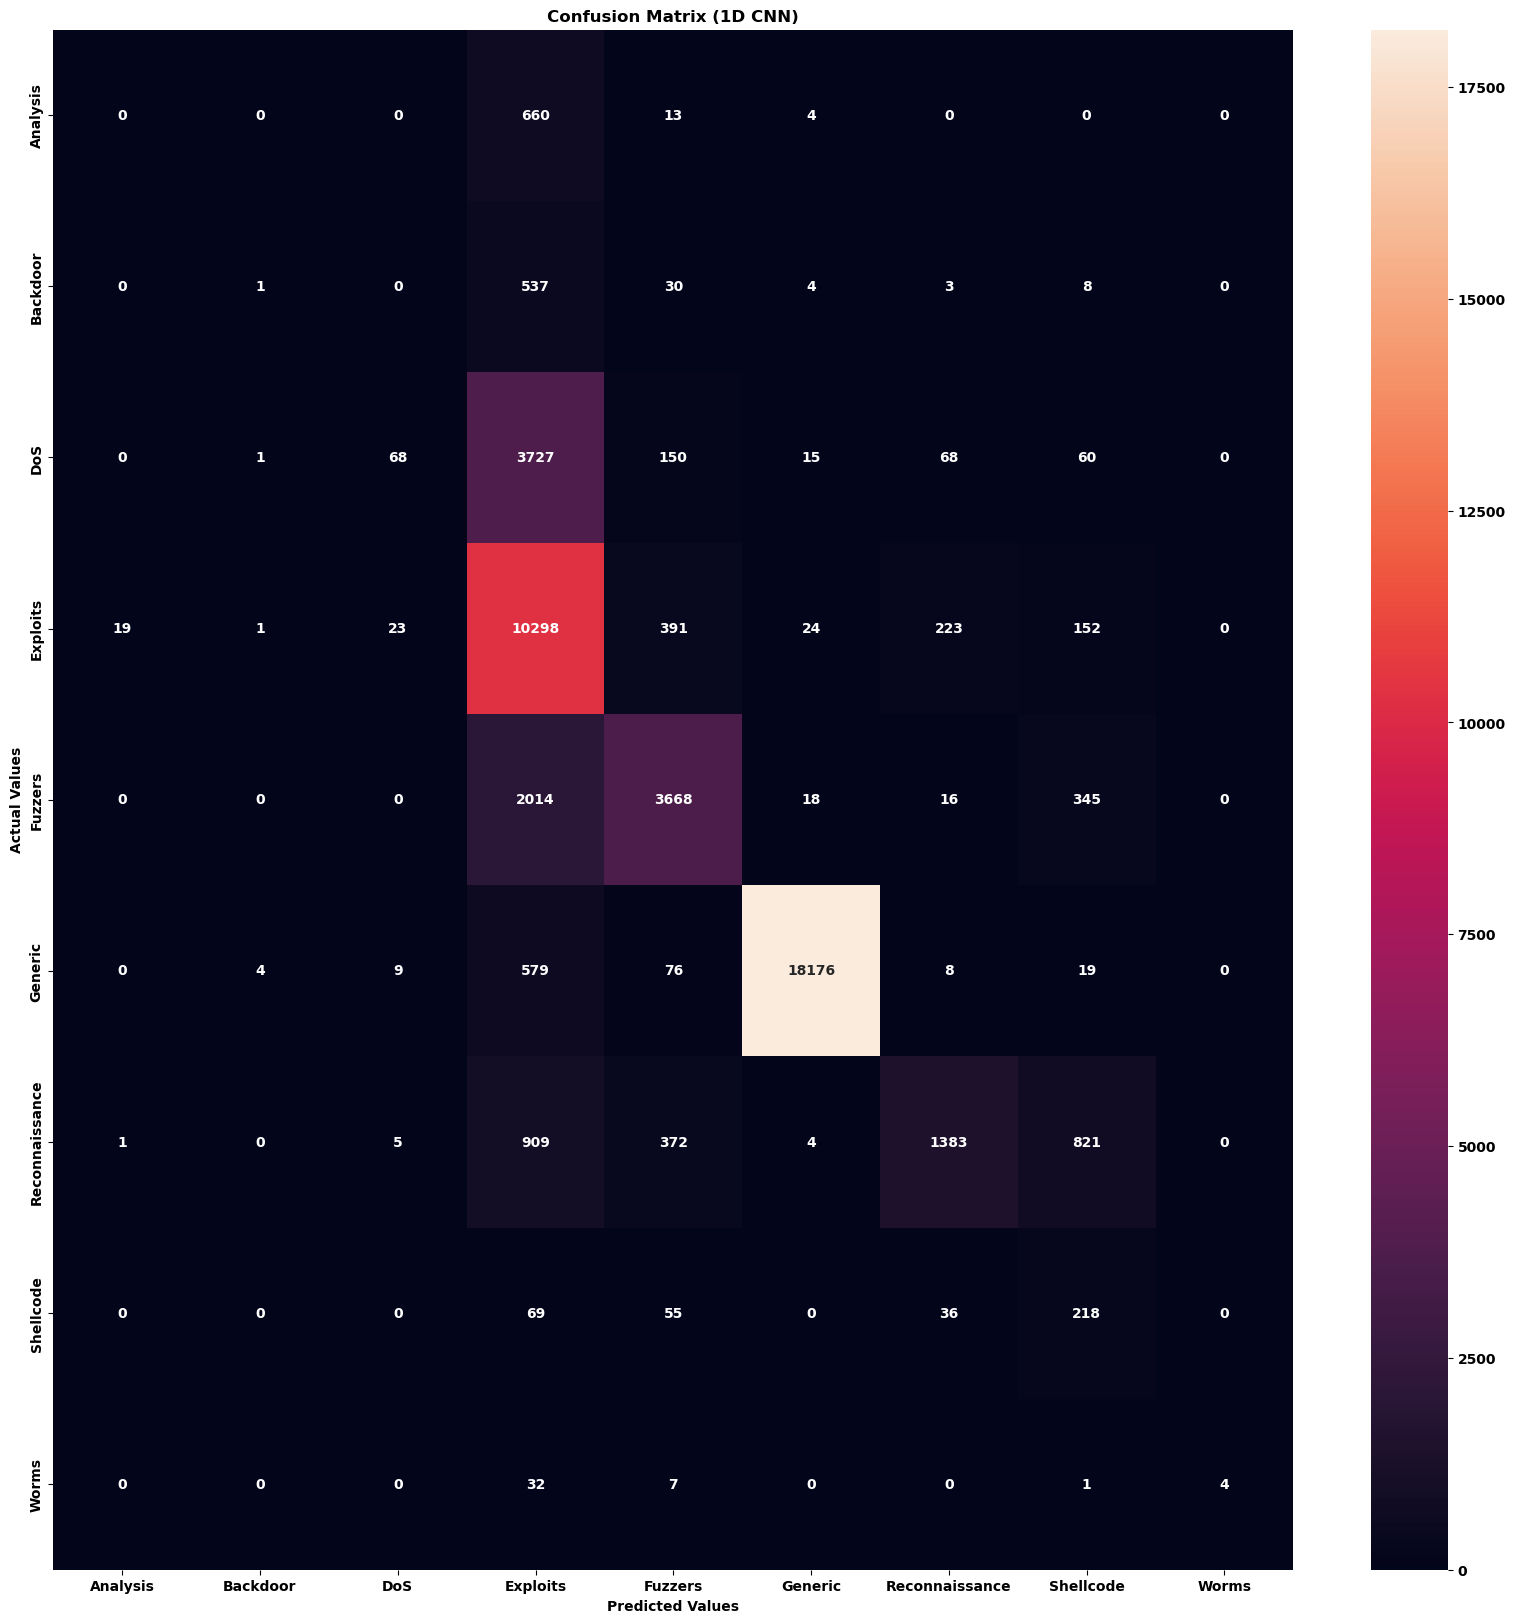

In [38]:
# Plotting Confusion Matrix
plt.figure(figsize = (20, 20))
sns.heatmap(matrix_df, fmt='.0f', annot=True)
plt.title('Confusion Matrix (1D CNN)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [39]:
recalls = calculate_recall(matrix)
display_recall(recalls)

Recall Scores for each class:
Analysis: 0.0
Backdoor: 0.0017152658662092624
DoS: 0.016629982880899976
Exploits: 0.9251639565178331
Fuzzers: 0.6051806632568884
Generic: 0.9631710031264904
Reconnaissance: 0.39570815450643776
Shellcode: 0.5767195767195767
Worms: 0.09090909090909091


## Save and load the model

In [40]:
from keras.models import load_model

In [41]:
# save the 1D CNN trained model using keras
model.save('/Data/Visual Studio Code/Data-Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/cnn1d.keras')

In [42]:
# load the 1D CNN trained model using keras
model = load_model('/Data/Visual Studio Code/Data-Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/cnn1d.keras')

## Save and load the predicted

In [44]:
import joblib

In [45]:
# save the predicted
joblib.dump(predicted_classes, 'D:/Data/Visual Studio Code/Data-Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/predicted_classes.joblib', compress=('zlib', 3))

['D:/Data/Visual Studio Code/Data-Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/predicted_classes.joblib']

In [46]:
# load the predicted
predicted_classes = joblib.load('D:/Data/Visual Studio Code/Data-Science/Notebook/UNSW-NB15/CNN/Imbalanced/Saved/predicted_classes.joblib')